# Determination of a prospective tariff for a telecom company

***Description of the project***
I am an analyst at Megaline, a federal mobile operator. Clients are offered two tariff plans: "Smart" and "Ultra". To adjust the advertising budget, the commercial department wants to understand which tariff brings in more money.
I have to do a preliminary analysis of tariffs on a small sample of customers. I have at my disposal the data of 500 Megaline users: who they are, where they are from, what tariff they use, how many calls and messages each sent in 2018. It is necessary to analyze the behavior of customers and draw a conclusion - which tariff is better

### Description of tariffs
- ***Smart Tariff***
- Monthly fee: 550 rubles
- Included 500 minutes of calls, 50 messages and 15 GB of internet traffic
- The cost of services above the tariff package:
- minute of conversation: 3 rubles
- message: 3 rubles
- 1 GB of Internet traffic: 200 rubles
-
- *** Tariff "Ultra" ***
- Monthly fee: 1950 rubles
- Included 3000 minutes of calls, 1000 messages and 30 GB of internet traffic
- The cost of services above the tariff package:
- minute of conversation: 1 ruble
- message: 1 ruble
- 1 GB of Internet traffic: 150 rubles


## Step 1. Open the data file and examine the general information

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce
from scipy import stats as st
import numpy as np

import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
calls = pd.read_csv("/datasets/calls.csv")
internet = pd.read_csv("/datasets/internet.csv")
messages = pd.read_csv("/datasets/messages.csv")
tariffs = pd.read_csv("/datasets/tariffs.csv")
users = pd.read_csv("/datasets/users.csv")
calls.info()
internet.info()
messages.info()
tariffs.info()
users.info()
display(users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 co

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


In [3]:
df = pd.read_csv('/datasets/users_behavior.csv')
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


## Step 2. Data preparation

***Data type replacement***

In [4]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format= '%Y-%m-%d') # Change value type to datetime64

del internet['Unnamed: 0']
internet['session_date'] = pd.to_datetime(internet['session_date'], format= '%Y-%m-%d') # Change value type to datetime64

messages['message_date'] = pd.to_datetime(messages['message_date'], format= '%Y-%m-%d') # Change value type to datetime64

users['churn_date'] = pd.to_datetime(users['churn_date'], format= '%Y-%m-%d') # Change value type to datetime64
users['reg_date'] = pd.to_datetime(users['reg_date'], format= '%Y-%m-%d') # Change value type to datetime64

***Correction of errors in the Date set***

0.0    39613
Name: duration, dtype: int64


Text(0.5, 1.0, 'Dependence of zero calls on the total number ')

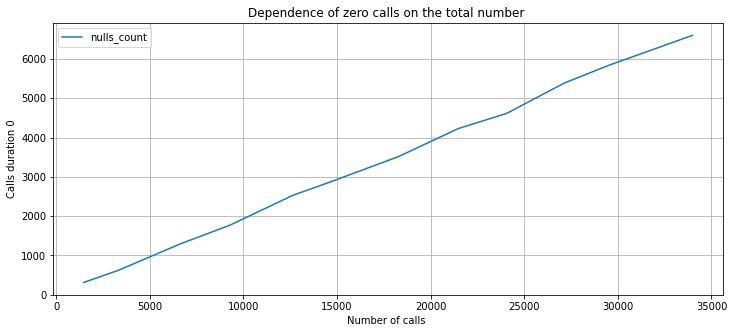

In [5]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month # add a column with the month value
# Number of calls with duration equal to zero
ziro = calls.loc[calls['duration'] == 0]
print(ziro['duration'].value_counts())

# Graph of the dependence of the number of calls and zero values
calls.loc[calls['duration'] == 0, 'nulls_count'] = 1
null_calls = calls.pivot_table(index='month', values=['id', 'nulls_count'], aggfunc='count')

null_calls.pivot_table(index='id', values='nulls_count').plot(grid=True, figsize=(12, 5))
plt.xlabel('Number of calls ')
plt.ylabel('Calls duration 0')
plt.title('Dependence of zero calls on the total number ')


Появление нулевых звонков сичтематично. Все значения округляем в большую сторону.

In [6]:
calls.loc[(calls['duration'] == 0)] = 1

0.0    19598
Name: mb_used, dtype: int64


Text(0.5, 1.0, 'Dependence of zero values on the total number ')

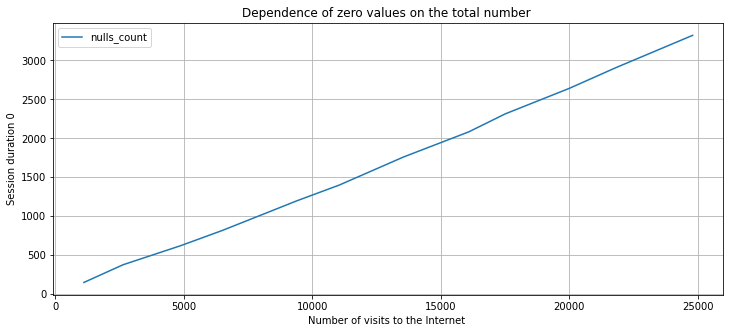

In [7]:
internet['month'] = pd.DatetimeIndex(internet['session_date']).month # add a column with the month value
# Number of traffic with duration equal to zero
ziro = internet.loc[internet['mb_used'] == 0]
print(ziro['mb_used'].value_counts())

# Graph of the dependence of the amount of traffic and zero values
internet.loc[internet['mb_used'] == 0, 'nulls_count'] = 1
null_internet = internet.pivot_table(index='month', values=['id', 'nulls_count'], aggfunc='count')

null_internet.pivot_table(index='id', values='nulls_count').plot(grid=True, figsize=(12, 5))
plt.xlabel('Number of visits to the Internet ')
plt.ylabel('Session duration 0')
plt.title('Dependence of zero values on the total number ')

In [8]:
# Everything is the same as with calls
internet.loc[(internet['mb_used'] == 0)] = 1

***Values for each user***

In [9]:
# Pivot call table
calls_users = calls.merge(users, on='user_id', how='inner')

calls_group = calls_users.pivot_table(values=['first_name', 'duration'], index=['user_id', 'month'],
                       aggfunc={'first_name': 'count', 'duration': 'sum'})
calls_group.columns = ['duration', 'calls']


# Pivot table of messages
messages['month'] = pd.DatetimeIndex(messages['message_date']).month # add a column with the month value
messages_users = messages.merge(users, on='user_id', how='inner')

messages_group = messages_users.pivot_table(values='first_name', index=['user_id', 'month'],
                       aggfunc={'first_name': 'count'})
messages_group.columns = ['messages']


# internet pivot table
internet_users = internet.merge(users, on='user_id', how='inner')

internet_group = internet_users.pivot_table(values=['first_name', 'mb_used'], index=['user_id', 'month'],
                       aggfunc={'first_name': 'count', 'mb_used': 'sum'})
internet_group.columns = ['mb_used', 'internet']


In [10]:
final_data = internet_group.merge(calls_group,on=['user_id', 'month'], how='outer')
final_data = final_data.merge(messages_group,on=['user_id', 'month'], how='outer')
final_data

mb_used  internet  duration  calls  messages
user_id month                                              
1000    5          4.0   2253.49    150.06   17.0      22.0
        6         44.0  23233.77    158.90   28.0      60.0
        7         28.0  14003.64    318.80   41.0      75.0
        8         27.0  14055.93    389.87   42.0      81.0
        9         25.0  14568.91    440.14   46.0      57.0
...                ...       ...       ...    ...       ...
1273    12         NaN       NaN    241.59   38.0      39.0
1365    10         NaN       NaN     40.85    5.0       1.0
1377    2          NaN       NaN    168.55   20.0       2.0
1392    2          NaN       NaN     11.96    2.0       3.0
1446    8          NaN       NaN     46.98    4.0       1.0

[3214 rows x 5 columns]

In [11]:
print(f'Number of clients: {final_data.reset_index().user_id.nunique()}')

Number of clients: 498


In [12]:
# replace forgiven values with zeros
final_data.loc[final_data['duration'].isna(), 'duration'] = 0
final_data.loc[final_data['messages'].isna(), 'messages'] = 0
final_data.loc[final_data['mb_used'].isna(), 'mb_used'] = 0

# Adding a tariff
for user in final_data.index:
     final_data.loc[user, 'tariff'] = users.loc[user[0]-1000, 'tariff']
display(final_data)

mb_used  internet  duration  calls  messages tariff
user_id month                                                     
1000    5          4.0   2253.49    150.06   17.0      22.0  ultra
        6         44.0  23233.77    158.90   28.0      60.0  ultra
        7         28.0  14003.64    318.80   41.0      75.0  ultra
        8         27.0  14055.93    389.87   42.0      81.0  ultra
        9         25.0  14568.91    440.14   46.0      57.0  ultra
...                ...       ...       ...    ...       ...    ...
1273    12         0.0       NaN    241.59   38.0      39.0  ultra
1365    10         0.0       NaN     40.85    5.0       1.0  smart
1377    2          0.0       NaN    168.55   20.0       2.0  ultra
1392    2          0.0       NaN     11.96    2.0       3.0  ultra
1446    8          0.0       NaN     46.98    4.0       1.0  smart

[3214 rows x 6 columns]

In [13]:
'''

The function returns how much the company has from each user by values

messages, mb_used, tariff, duration using the rules:

Subtract the free limit from all, messages and Internet traffic and calls.

the balance over the limit will be multiplied by the values ​​from the tariff plan.

Then add the subscription fee.

'''
def user_pay(row):
    messages = row['messages']
    mb_used = row['mb_used']
    tariff = row['tariff']
    duration = row['duration']
    
    if tariff == 'smart':
        extra_duration = duration - tariffs.loc[0, 'minutes_included']
        extra_mb = mb_used - tariffs.loc[0, 'mb_per_month_included']
        extra_messages = messages - tariffs.loc[0, 'messages_included']
        
        if extra_duration < 0:
            extra_duration = 0
        if extra_mb < 0:
            extra_mb=0
        if extra_messages < 0:
            extra_messages = 0
        
        mes1 = tariffs.loc[0, 'rub_per_message'] * extra_messages
        traf1 = (tariffs.loc[0, 'rub_per_gb'] / 1024) * extra_mb
        min1 = tariffs.loc[0, 'rub_per_minute'] * extra_duration
        
        return mes1 + traf1 + min1 + tariffs.loc[0, 'rub_monthly_fee']
                  
    else:
        extra_duration = duration - tariffs.loc[1, 'minutes_included']
        extra_mb = mb_used - tariffs.loc[1, 'mb_per_month_included']
        extra_messages = messages - tariffs.loc[1, 'messages_included']
                
        if extra_duration < 0:
            extra_duration = 0
        if extra_mb < 0:
            extra_mb=0
        if extra_messages < 0:
            extra_messages = 0
        
        mes2 = tariffs.loc[1, 'rub_per_message'] * extra_messages
        traf2 = (tariffs.loc[1, 'rub_per_gb'] / 1024) * extra_mb
        min2 = tariffs.loc[1, 'rub_per_minute'] * extra_duration
        
        return mes2 + traf2 + min2 + tariffs.loc[1, 'rub_monthly_fee']
                  

final_data['user_pays'] = final_data.apply(user_pay, axis=1)

## Step 3. Data Analysis

In [14]:
# How many messages, internet and calls each user needs on average
median_found = final_data.pivot_table(index='user_id', values=['duration', 'messages', 'mb_used', 'user_pays'], aggfunc='median')
for user_id in users['user_id']:
     median_found.loc[user_id, 'tariff'] = users.loc[user_id-1000, 'tariff']
median_found.head()


,duration,mb_used,messages,user_pays,tariff
user_id,,,,,
1000,318.920,26.0,65.0,1950.0,ultra
1001,399.730,41.0,0.0,550.0,smart
1002,204.750,44.0,11.0,550.0,smart
1003,775.390,21.0,83.0,1950.0,ultra
1004,123.935,33.0,154.5,1950.0,ultra


In [15]:
median_found.dropna(subset=['duration'], inplace=True)
ultra = median_found[median_found['tariff'] == 'ultra']
smart = median_found[median_found['tariff'] == 'smart']
print(ultra.median()) # median
print(np.var(ultra)) # sample variance
print(np.std(ultra)) # sample standard deviation
print(smart.median()) # median
print(np.var(smart)) # sample variance
print(np.std(smart)) # sample standard deviation

duration      506.9225
mb_used        37.0000
messages       47.5000
user_pays    1950.0000
dtype: float64
duration     81554.883453
mb_used        281.901844
messages      2407.883161
user_pays        0.000000
dtype: float64
duration     285.578156
mb_used       16.789933
messages      49.070186
user_pays      0.000000
dtype: float64
duration     415.39
mb_used       44.00
messages      28.50
user_pays    550.00
dtype: float64
duration     22883.670708
mb_used        113.133553
messages       782.354957
user_pays    38968.244981
dtype: float64
duration     151.273496
mb_used       10.636426
messages      27.970609
user_pays    197.403761
dtype: float64


In all respects, the Ultra tariff is ahead of its competitor. The median is shifted upwards. It also has a large dispersion.

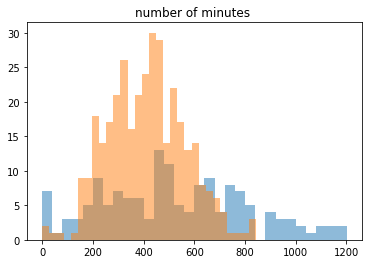

In [16]:
plt.title('number of minutes ')
x = ultra['duration']
y = smart['duration']

plt.hist(x, bins=30, alpha=0.5, label='ultra')
plt.hist(y, bins=30, alpha=0.5, label='smart')
plt.show()

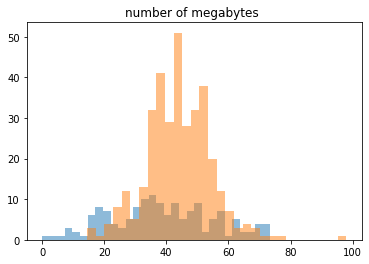

In [17]:
plt.title('number of megabytes ')
x = ultra['mb_used']
y = smart['mb_used']

plt.hist(x, bins=30, alpha=0.5, label='ultra')
plt.hist(y, bins=30, alpha=0.5, label='smart')
plt.show()

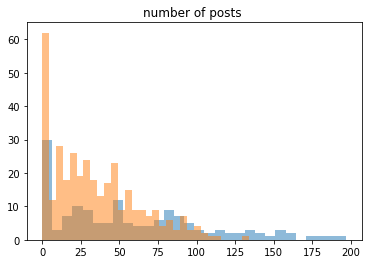

In [18]:
plt.title('number of posts ')
x = ultra['messages']
y = smart['messages']

plt.hist(x, bins=30, alpha=0.5, label='ultra')
plt.hist(y, bins=30, alpha=0.5, label='smart')
plt.show()

Cheaper fare has more emissions. It seems to me that when buying a cheap tariff, people try not to go beyond the scope of the package, but they don’t care about the expensive one. because it is very difficult to spend the whole package.

## Step 4. Hypothesis testing

***We are testing the hypothesis that the averages of two independent sets are equal, the average amount of money spent in 2 ultra and smart tariffs***
- H1 = the amount of money spent in 2 ultra and smart tariffs is equal to
- H0 = amount of money spent in 2 ultra and smart tariffs are different

In [19]:
ult = ultra['user_pays']
smt = smart['user_pays']


alpha = .05

results = st.ttest_ind(
    ult,
     smt)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
     print("Reject the null hypothesis")
else:
     print("Failed to reject null hypothesis")

p-value: 5.777676548056522e-284
Reject the null hypothesis


/tmp/ipykernel_541/3532516097.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results = st.ttest_ind(


In [20]:
print('median:', ult.median())
print('median:', smt.median(),'\n')
print('sample variance:', np.var(ult)) # sample variance
print('sample variance:', np.var(smt),'\n') # sample variance
print('sample standard deviation:', np.std(ult)) # sample standard deviation
print('sample standard deviation:', np.std(smt)) # sample standard deviation

median: 1950.0
median: 550.0 

sample variance: 0.0
sample variance: 38968.24498108347 

sample standard deviation: 0.0
sample standard deviation: 197.40376131442753


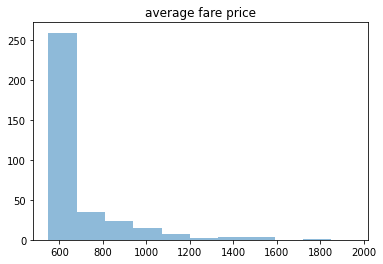

In [21]:
plt.title('average fare price')
x=ult
y=smt

plt.hist(y, alpha=0.5, label='ultra')
plt.hist(x, alpha=0.5, label='smart')
plt.show()

The average value differs by almost 4 times. We can definitely say that the Ulra tariff is more profitable for the company.

***We are testing the hypothesis about the equality of the averages of two independent sets of the average amount of money spent by users in Moscow and other cities***
- H0 = the average amount of money spent by users in Moscow and other cities is
- H1 = the average amount of money spent by users of Moscow and other cities is different

In [22]:
for user in final_data.index:
     final_data.loc[user, 'city'] = users.loc[user[0]-1000, 'city']
    
moscow = final_data.query('city == "Moscow"')['user_pays']
other = final_data.query('city != "Moscow"')['user_pays']

alpha = .05

results = st.ttest_ind(
     moscow,
     other)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
     print("Reject the null hypothesis")
else:
     print("Failed to reject null hypothesis")

p-value: nan
Failed to reject null hypothesis


In [23]:
print('median:', moscow.median())
print('median:', other.median(),'\n')
print('sample variance:',np.var(moscow)) # sample variance
print('sample variance:',np.var(other),'\n') # sample variance
print('sample standard deviation:',np.std(moscow)) # sample standard deviation
print('sample standard deviation:',np.std(other)) # sample standard deviation

median: nan
median: 640.3000000000001 

sample variance: nan
sample variance: 387995.4242249586 

sample standard deviation: nan
sample standard deviation: 622.8927871030123


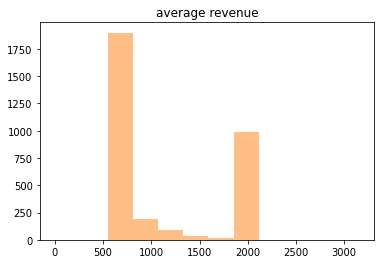

In [24]:
plt.title('average revenue')
x = moscow
y = other

plt.hist(x, alpha=0.5, label='moscow')
plt.hist(y, alpha=0.5, label='other')
plt.show()

The average revenue of users from Moscow differs from the revenue of users from other regions. Since we reject the null hypothesis.
I don't think the difference is that big.
In both cases, I used the hypothesis that the means of the two populations are equal

## Step 5. General conclusion

The ultra tariff brings more than smart about 4 times 1950 against 556 rubles.
In Moscow, people spend about the same amount on communications as in the regions.
Users of the ultra tariff do not have time to use the entire package, but subscribers using the smart tariff, on the contrary, almost all buy additional services.




***The guys from the marketing department can be recommended to promote the ultra tariff)***

## Step 6. Splitting data into samples

In [25]:
from sklearn.model_selection import train_test_split



# Separation of training set and validation set
train, test_valid_features = train_test_split(df, test_size=40, random_state=12345)
test, valid = train_test_split(test_valid_features, test_size=20, random_state=12345)


# variables for features and target feature
features_train = train.drop(['is_ultra'], axis=1)
target_train = train['is_ultra']

features_valid = valid.drop(['is_ultra'], axis=1)
target_valid = valid['is_ultra']

features_test = test.drop(['is_ultra'], axis=1)
target_test = test['is_ultra']

***I divided the data into a ratio of 60-20-20.***

- for training 60%
- validation and test sets of 20
- the model will be trained on the last column

## Step 7. Model research

In [26]:
%%time

best_model = None
best_result = 0
for depth in range(1, 10): # tree depth
    model1 = DecisionTreeClassifier(random_state=12345, max_depth = depth)
    model1.fit(features_train, target_train) # model training
    predictions1 = model1.predict(features_valid) # Predictions
    result1 = accuracy_score(target_valid, predictions1) # Check
    if result1 > best_result:
        best_model = model1 # best model
        best_result = result1 # best accuracy
        
print("Accuracy:", best_result)
print("Best model:", best_model)

Accuracy: 0.8
Best model: DecisionTreeClassifier(max_depth=7, random_state=12345)
CPU times: user 72 ms, sys: 3.96 ms, total: 75.9 ms
Wall time: 74.7 ms


***Decision tree model***

- The model gives a good result, but it is very easy to retrain
- average speed
- the optimal depth of the tree is 7

In [27]:
%%time

best_model = None
best_result = 0
for est in range(1, 20, 1):
    model2 = RandomForestClassifier(random_state=12345, n_estimators=est)
    model2.fit(features_train, target_train)
    predictions2 = model2.predict(features_valid)
    result2 = accuracy_score(target_valid, predictions2)
    if result2 > best_result:
        best_model = model2# best model
        best_result = result2# best value of accuracy metric on validation data

print("Accuracy:", best_result)
print("Best model:", best_model)

Accuracy: 0.8
Best model: RandomForestClassifier(n_estimators=5, random_state=12345)
CPU times: user 1.07 s, sys: 3.34 ms, total: 1.07 s
Wall time: 1.08 s


***Random Forest***
- takes a very long time
- best result
- optimal number of trees 5

In [28]:
%%time

model3 = LogisticRegression(random_state=12345) # logistic regression model with random_state=12345
model3.fit(features_train, target_train) # model training
predictions3 = model3.predict(features_valid)
result3 = accuracy_score(target_valid, predictions3) # model quality metric on the validation set

print("Accuracy:", result3)

Accuracy: 0.75
CPU times: user 166 ms, sys: 222 ms, total: 388 ms
Wall time: 343 ms


***Logic Regression***

- the fastest
- not a very good indicator of Accuracy. Not even 75%

## Step 8. Checking models on a test set

In [29]:
# Accuracy on the test set
result1 = model1.score(features_test, target_test)
result2 = model2.score(features_test, target_test)
result3 = model3.score(features_test, target_test)
print(result1)
print(result2)
print(result3)

0.85
0.95
0.85


***After checking on the test sample, we can conclude that:***

- The most accurate model is random forest
- In second place Decision Tree
- And the fastest, but not accurate, is the regression model

## Step 9. Check models for adequacy

To test the classification model, you need to compare the Accuracy result with a random value. This is 50%

- ***In our case it is:***
- 85% - wood
- 95% - forest
- 85% - regression
- All 3 models are the same and perform their function. They don't do it with 100% accuracy though.

## Conclusion

The best model is Random Forest. Although it takes a long time, it has better accuracy. Other models will work too. Let's say a decision tree gets a good result, but if you overdo it with the number of trees, you can very easily retrain it. The regression produces the worst result, but better than 50%. In this model, accuracy suffers due to the speed of its execution.